In [8]:
import pandas as pd
import os

base_path = "/global/scratch/users/zhoufd/TCR/"
cns_path = f"{base_path}/data/CNS_0605_config_5prime_2runs/outs/per_sample_outs/CNS_0605_config_5prime_2runs/vdj_t/filtered_contig_annotations.csv"
spleen_path= f"{base_path}/data/Spleen_0605_config_5prime_2runs/outs/per_sample_outs/Spleen_0605_config_5prime_2runs/vdj_t/filtered_contig_annotations.csv"

# Strict filtering for the TCRs based on scirpy analysis
filtered_meta = pd.read_csv(f"{base_path}/saved_data/integrated_data/strict_filtered_meta.csv")
barcodes_set = set(filtered_meta.iloc[:,0])
cns_0605_ids = {b.split("_")[0] for b in barcodes_set if "CNS_0605" in b}
spleen_0605_ids = {b.split("_")[0] for b in barcodes_set if "Spleen_0605" in b}


# Define output directories
output_dir = "/global/scratch/users/zhoufd/TCR/saved_data/DeepTCR_input2"
cns_dir = os.path.join(output_dir, "CNS")
spleen_dir = os.path.join(output_dir, "Spleen")

# Create folders if they don't exist
os.makedirs(cns_dir, exist_ok=True)
os.makedirs(spleen_dir, exist_ok=True)

# Function to filter for high-confidence, productive TCR Beta (TRB) chains
def strict_filter_tcr_beta(df,ids):
    return df[
        (df["barcode"].isin(ids)) &
        (df["high_confidence"] == True) &
        (df["productive"] == True) &
        (df["chain"] == "TRB")
    ][["cdr3", "v_gene","j_gene"]].dropna()

    # Remove multiple V-Beta/J-Beta notations (keep only the first one if multiple exist)
    df["v_gene"] = df["v_gene"].apply(lambda x: x.split("+")[0] if "+" in x else x)
    df["j_gene"] = df["j_gene"].apply(lambda x: x.split("+")[0] if "+" in x else x)

    return df

# Apply filtering
cns_filtered = strict_filter_tcr_beta(pd.read_csv(cns_path),cns_0605_ids)
spleen_filtered = strict_filter_tcr_beta(pd.read_csv(spleen_path),spleen_0605_ids)

# Add count column (each row initially counts as 1)
cns_filtered["count"] = 1
spleen_filtered["count"] = 1

# Resolve V-Beta/J-Beta conflicts by selecting the most common one per CDR3
def resolve_vj_conflicts(group):
    v_gene = group["v_gene"].value_counts().idxmax() if len(group["v_gene"].unique()) > 1 else group["v_gene"].iloc[0]
    j_gene = group["j_gene"].value_counts().idxmax() if len(group["j_gene"].unique()) > 1 else group["j_gene"].iloc[0]
    count = group["count"].sum()  # Sum counts for duplicate CDR3s
    return pd.Series([count, v_gene, j_gene], index=["count", "v_gene", "j_gene"])

# Process CNS and Spleen separately
cns_final = cns_filtered.groupby("cdr3").apply(resolve_vj_conflicts).reset_index()
spleen_final = spleen_filtered.groupby("cdr3").apply(resolve_vj_conflicts).reset_index()

# Reorder columns to match format: beta, counts, v_beta, j_beta
cns_final = cns_final[["cdr3", "count", "v_gene", "j_gene"]]
spleen_final = spleen_final[["cdr3", "count", "v_gene", "j_gene"]]

# Save CNS and Spleen data separately
cns_output_file = os.path.join(cns_dir, "CNS.tsv")
spleen_output_file = os.path.join(spleen_dir, "Spleen.tsv")

# Ensure headers are included
cns_final.to_csv(cns_output_file, sep="\t", index=False, header=["beta", "counts", "v_beta", "j_beta"])
spleen_final.to_csv(spleen_output_file, sep="\t", index=False, header=["beta", "counts", "v_beta", "j_beta"])

print(f"Saved CNS sequences to: {cns_output_file}")
print(f"Saved Spleen sequences to: {spleen_output_file}")


Saved CNS sequences to: /global/scratch/users/zhoufd/TCR/saved_data/DeepTCR_input2/CNS/CNS.tsv
Saved Spleen sequences to: /global/scratch/users/zhoufd/TCR/saved_data/DeepTCR_input2/Spleen/Spleen.tsv


### Old read data. DONT' RUN!!

In [2]:
import pandas as pd
import os

# File Paths
cns_path = "/global/scratch/users/zhoufd/TCR/data/CNS_0516_config_5prime_2runs/outs/per_sample_outs/CNS_0516_config_5prime_2runs/vdj_t/filtered_contig_annotations.csv"
spleen_path = "/global/scratch/users/zhoufd/TCR/data/Spleen_0516_config_5prime_2runs/outs/per_sample_outs/Spleen_0516_config_5prime_2runs/vdj_t/filtered_contig_annotations.csv"

# Define output directories
output_dir = "/global/scratch/users/zhoufd/TCR/saved_data/DeepTCR_input"
cns_dir = os.path.join(output_dir, "CNS")
spleen_dir = os.path.join(output_dir, "Spleen")

# Create folders if they don't exist
os.makedirs(cns_dir, exist_ok=True)
os.makedirs(spleen_dir, exist_ok=True)

# Function to filter for high-confidence, productive TCR Beta (TRB) chains
def filter_tcr_beta(df):
    df = df[
        (df["is_cell"] == True) &
        (df["high_confidence"] == True) &
        (df["productive"] == True) &
        (df["chain"] == "TRB")
    ][["cdr3", "v_gene", "j_gene"]].dropna()

    # Remove multiple V-Beta/J-Beta notations (keep only the first one if multiple exist)
    df["v_gene"] = df["v_gene"].apply(lambda x: x.split("+")[0] if "+" in x else x)
    df["j_gene"] = df["j_gene"].apply(lambda x: x.split("+")[0] if "+" in x else x)

    return df

# Apply filtering
cns_filtered = filter_tcr_beta(pd.read_csv(cns_path))
spleen_filtered = filter_tcr_beta(pd.read_csv(spleen_path))

# Add count column (each row initially counts as 1)
cns_filtered["count"] = 1
spleen_filtered["count"] = 1

# Resolve V-Beta/J-Beta conflicts by selecting the most common one per CDR3
def resolve_vj_conflicts(group):
    v_gene = group["v_gene"].value_counts().idxmax() if len(group["v_gene"].unique()) > 1 else group["v_gene"].iloc[0]
    j_gene = group["j_gene"].value_counts().idxmax() if len(group["j_gene"].unique()) > 1 else group["j_gene"].iloc[0]
    count = group["count"].sum()  # Sum counts for duplicate CDR3s
    return pd.Series([count, v_gene, j_gene], index=["count", "v_gene", "j_gene"])

# Process CNS and Spleen separately
cns_final = cns_filtered.groupby("cdr3").apply(resolve_vj_conflicts).reset_index()
spleen_final = spleen_filtered.groupby("cdr3").apply(resolve_vj_conflicts).reset_index()

# Reorder columns to match format: beta, counts, v_beta, j_beta
cns_final = cns_final[["cdr3", "count", "v_gene", "j_gene"]]
spleen_final = spleen_final[["cdr3", "count", "v_gene", "j_gene"]]

# Save CNS and Spleen data separately
cns_output_file = os.path.join(cns_dir, "CNS.tsv")
spleen_output_file = os.path.join(spleen_dir, "Spleen.tsv")

# Ensure headers are included
cns_final.to_csv(cns_output_file, sep="\t", index=False, header=["beta", "counts", "v_beta", "j_beta"])
spleen_final.to_csv(spleen_output_file, sep="\t", index=False, header=["beta", "counts", "v_beta", "j_beta"])

print(f"Saved CNS sequences to: {cns_output_file}")
print(f"Saved Spleen sequences to: {spleen_output_file}")



Saved CNS sequences to: /global/scratch/users/zhoufd/TCR/saved_data/DeepTCR_input/CNS/CNS.tsv
Saved Spleen sequences to: /global/scratch/users/zhoufd/TCR/saved_data/DeepTCR_input/Spleen/Spleen.tsv


### Analysis

In [1]:
from DeepTCR.DeepTCR import DeepTCR_U

# Instantiate training object
DTCRU = DeepTCR_U('TCR_Analysis')

# Path to your dataset
data_directory = "/global/scratch/users/zhoufd/TCR/saved_data/DeepTCR_input2"

# Load Data from CNS & Spleen directories
DTCRU.Get_Data(directory=data_directory, Load_Prev_Data=False, aggregate_by_aa=True,
               aa_column_beta=0, count_column=1, v_beta_column=2, j_beta_column=3)

print("Data loaded successfully into DeepTCR!")


Matplotlib is building the font cache; this may take a moment.


Loading Data...
Embedding Sequences...
Data Loaded
Data loaded successfully into DeepTCR!


In [15]:
# Train Variational Autoencoder (VAE) with adjusted parameters
DTCRU.Train_VAE(
    latent_dim=96,          # Reduce latent dimension to prevent overfitting on 20K sequences
    batch_size=5000,         # Reduce batch size to prevent memory overload
    epochs_min=5,            # Ensure at least 5 training epochs
    stop_criterion_window=30, # Increase patience for stopping
    learning_rate=0.001,    # Slightly slower learning rate for better stability
    Load_Prev_Data=False     # Ensure fresh training
)

print("DeepTCR VAE training completed!")


/global/home/users/zhoufd/.conda/envs/deeptcr_env/lib/python3.8/site-packages/DeepTCR/functions/Layers.py:105: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  conv = tf.compat.v1.layers.conv2d(inputs, units[ii], (1, kernel), 1, padding='same',
/global/home/users/zhoufd/.conda/envs/deeptcr_env/lib/python3.8/site-packages/keras/legacy_tf_layers/convolutional.py:563: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/global/home/users/zhoufd/.conda/envs/deeptcr_env/lib/python3.8/site-packages/DeepTCR/functions/Layers.py:107: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  conv_out = tf.compat.v1.layers.flatten(tf.reduce_max(input_tensor=conv, axis=2))
/global/home/users/zhoufd/.conda/envs/deeptcr_env/lib/python3.8/

Epoch = 0, Iteration = 0 Total Loss: 7.06701: Recon Loss: 7.03611: Latent Loss: 0.03089: Sparsity Loss: 0.00000: Recon Accuracy: 0.06389
Epoch = 0, Iteration = 1 Total Loss: 6.87949: Recon Loss: 6.84893: Latent Loss: 0.03056: Sparsity Loss: 0.00000: Recon Accuracy: 0.08498
Epoch = 0, Iteration = 2 Total Loss: 6.73702: Recon Loss: 6.70453: Latent Loss: 0.03249: Sparsity Loss: 0.00000: Recon Accuracy: 0.09907
Epoch = 0, Iteration = 3 Total Loss: 6.66253: Recon Loss: 6.62505: Latent Loss: 0.03748: Sparsity Loss: 0.00000: Recon Accuracy: 0.10620
Epoch = 0, Iteration = 4 Total Loss: 6.59197: Recon Loss: 6.54885: Latent Loss: 0.04312: Sparsity Loss: 0.00000: Recon Accuracy: 0.12108
Epoch = 1, Iteration = 0 Total Loss: 6.50549: Recon Loss: 6.45952: Latent Loss: 0.04597: Sparsity Loss: 0.00000: Recon Accuracy: 0.15267
Epoch = 1, Iteration = 1 Total Loss: 6.41514: Recon Loss: 6.36989: Latent Loss: 0.04525: Sparsity Loss: 0.00000: Recon Accuracy: 0.17484
Epoch = 1, Iteration = 2 Total Loss: 6.38

In [16]:
import pandas as pd

def extract_features_from_DTCRU(DTCRU):
    """
    Extracts latent features along with CDR3 sequences, V-beta, J-beta, and labels into a DataFrame.

    Args:
        DTCRU: The feature_analytics_class instance.

    Returns:
        Pandas DataFrame containing:
        - Features (latent embeddings)
        - CDR3 Beta Sequences
        - V_beta, J_beta
        - Labels (Sample/Cluster ID)
    """

    # Convert latent features to DataFrame
    feature_df = pd.DataFrame(DTCRU.features)

    # Convert sequence data to DataFrame
    metadata_df = pd.DataFrame({
        "CDR3_Beta": DTCRU.beta_sequences,
        "V_Beta": DTCRU.v_beta,
        "J_Beta": DTCRU.j_beta,
        "Label": DTCRU.sample_id  # Use sample_id as labels
    })

    # Merge latent features with metadata
    full_df = pd.concat([metadata_df, feature_df], axis=1)

    return full_df

# Usage:
features_df = extract_features_from_DTCRU(DTCRU)

# Save to CSV if needed
features_df.to_csv("/global/scratch/users/zhoufd/TCR/saved_data/DTCRU_extracted_features_96.csv", index=False)

#features_df 

In [17]:
# # Reduce clusters by lowering PhenoGraph resolution (t)
# DTCRU.Cluster(
#     clustering_method='phenograph',  # Keep PhenoGraph clustering
#     t=5,                     # Lower resolution (default ~30); reduce for fewer clusters
#     n_jobs=4                 # Use multiple threads for efficiency
# )
DTCRU.Cluster(
    set='all', 
    clustering_method='dbscan',  # Use DBSCAN
    t=6,  # Higher values merge clusters (default is auto-tuned)
    n_jobs=4
)

Clustering Done


In [20]:
DFs = DTCRU.Cluster_DFs
len(DFs)

225

In [21]:

print(DFs[0])

     index Alpha_Sequences    Beta_Sequences V_alpha J_alpha V_beta D_beta  \
0        0            None  CTCSADPGVNQDTQYF    None    None  TRBV1   None   
1      327            None    CTCSPGQGEDTQYF    None    None  TRBV1   None   
2      345            None     CTCSAADKDTQYF    None    None  TRBV1   None   
3     1208            None     CTCRRGVEDTQYF    None    None  TRBV1   None   
4     1230            None   CTCSADGVNQDTQYF    None    None  TRBV1   None   
..     ...             ...               ...     ...     ...    ...    ...   
128  11150            None       CTCSAEDTQYF    None    None  TRBV1   None   
129  11164            None   CTCSADWGYQDTQYF    None    None  TRBV1   None   
130  11188            None   CTCSADTGAQDTQYF    None    None  TRBV1   None   
131  11191            None     CTCSADSRDTQYF    None    None  TRBV1   None   
132  11199            None   CTCSADSGGAGTQYF    None    None  TRBV1   None   

      J_beta  Frequency  Labels      Sample           HLA  
0  

In [10]:
# import matplotlib.pyplot as plt

# # Initialize lists to store cluster indices and weighted CNS proportions
# cluster_ids = []
# cns_proportions = []

# # Iterate through clusters and compute weighted CNS proportions
# for i, df in enumerate(DFs):
#     total_freq = df["Frequency"].sum()  # Sum of frequencies in cluster
#     cns_freq = df.loc[df["Labels"] == "CNS", "Frequency"].sum()  # Sum of CNS frequencies
    
#     # Avoid division by zero
#     cns_ratio = cns_freq #/ total_freq if total_freq > 0 else 0
    
#     cluster_ids.append(i + 1)  # Cluster numbers start from 1
#     cns_proportions.append(cns_ratio)

# # Plot CNS proportion per cluster
# plt.figure(figsize=(12, 6))
# plt.bar(cluster_ids, cns_proportions, color="dodgerblue")

# plt.xlabel("Cluster")
# plt.ylabel("CNS Proportion (Weighted by Frequency)")
# plt.title("Weighted Proportion of CNS Sequences in Each Cluster")
# #plt.ylim(0, 1)  # Set proportion range between 0 and 1
# plt.xticks(rotation=90)  # Rotate x-axis labels if needed
# plt.show()
# import matplotlib.pyplot as plt

# # Initialize lists to store cluster indices and weighted CNS proportions
# cluster_ids = []
# cns_proportions = []

# # Iterate through clusters and compute weighted CNS proportions
# for i, df in enumerate(DFs):
#     total_freq = df["Frequency"].sum()  # Sum of frequencies in cluster
#     cns_freq = df.loc[df["Labels"] == "Spleen", "Frequency"].sum()  # Sum of CNS frequencies
    
#     # Avoid division by zero
#     cns_ratio = cns_freq #/ total_freq if total_freq > 0 else 0
    
#     cluster_ids.append(i + 1)  # Cluster numbers start from 1
#     cns_proportions.append(cns_ratio)

# # Plot CNS proportion per cluster
# plt.figure(figsize=(12, 6))
# plt.bar(cluster_ids, cns_proportions, color="dodgerblue")

# plt.xlabel("Cluster")
# plt.ylabel("Spleen Proportion (Weighted by Frequency)")
# plt.title("Weighted Proportion of CNS Sequences in Each Cluster")
# #plt.ylim(0, 1)  # Set proportion range between 0 and 1
# plt.xticks(rotation=90)  # Rotate x-axis labels if needed
# plt.show()

/global/home/users/zhoufd/.conda/envs/deeptcr_env/lib/python3.8/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


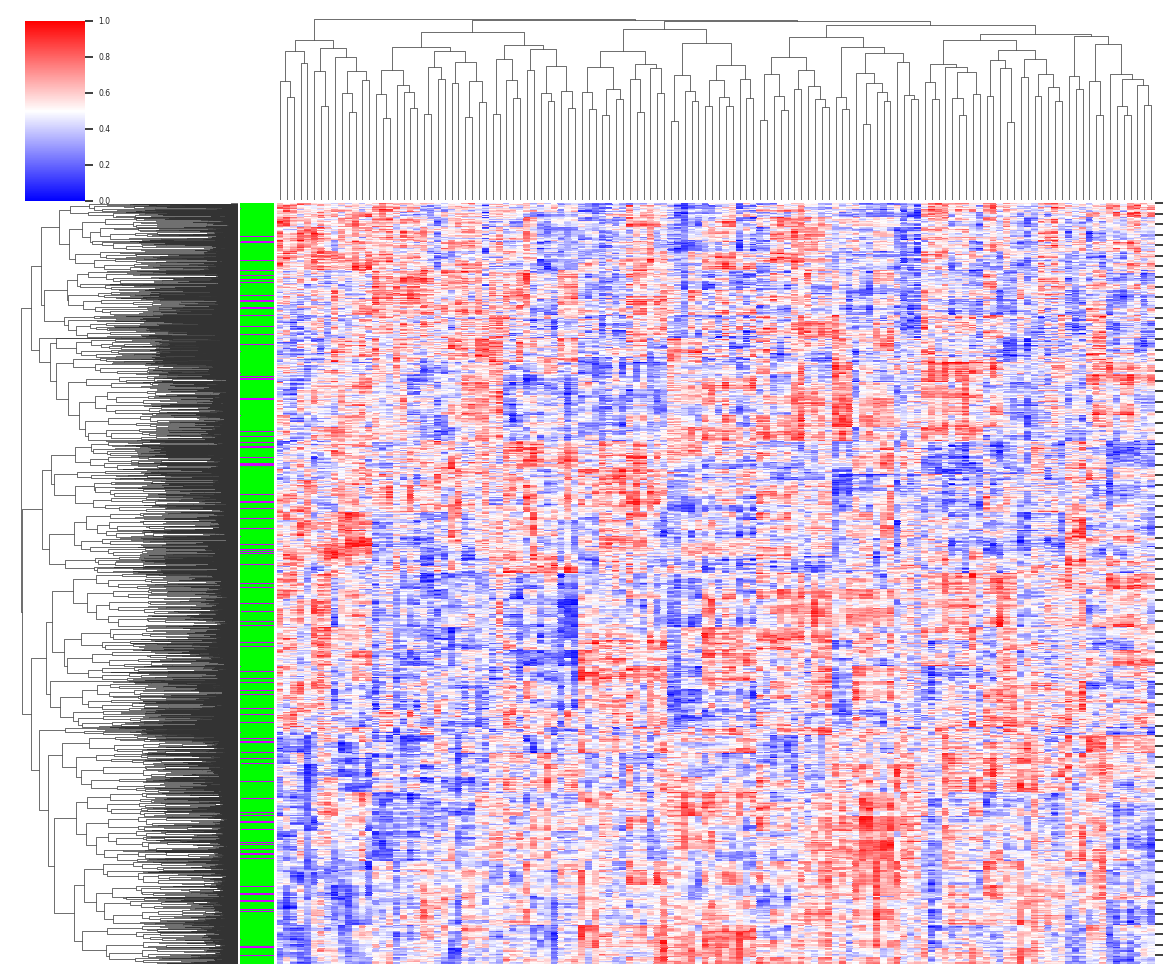

<Figure size 640x480 with 0 Axes>

In [22]:
DTCRU.HeatMap_Sequences()

In [23]:
DTCRU.Structural_Diversity()

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 10.076035737991333 seconds
Jaccard graph constructed in 7.192243337631226 seconds
Wrote graph to binary file in 1.9444057941436768 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.993718
Louvain completed 21 runs in 4.286612033843994 seconds
PhenoGraph complete in 23.568793058395386 seconds


In [1]:
DTCRU.Structural_Diversity_DF

NameError: name 'DTCRU' is not defined

In [25]:
# Extract normalized frequency and sample IDs from DeepTCR
normalized_freq = np.array(DTCRU.freq)  # Already normalized per sample
sample_ids = np.array(DTCRU.sample_id)

# Count the number of sequences in CNS and Spleen
num_cns = np.sum(sample_ids == "CNS.tsv")
num_spleen = np.sum(sample_ids == "Spleen.tsv")

# Compute rescaling factor: adjust Spleen frequencies to match CNS scale
scale_factor = num_spleen / num_cns

# Rescale the Spleen frequencies only
adjusted_freq = np.where(sample_ids == "Spleen.tsv", normalized_freq * scale_factor, normalized_freq)
DTCRU.freq = adjusted_freq

In [32]:
DTCRU.freq

array([0.01543312, 0.01410554, 0.01228012, ..., 0.00030548, 0.00030548,
       0.00030548])

In [26]:
scale_factor

7.274740978921043

In [27]:
num_cns

2799

In [28]:
num_spleen

20362

In [29]:
DTCRU.freq

array([0.01543312, 0.01410554, 0.01228012, ..., 0.00030548, 0.00030548,
       0.00030548])

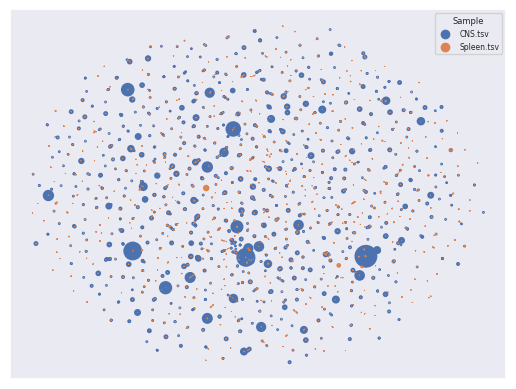

In [30]:
DTCRU.UMAP_Plot(Load_Prev_Data=True,by_sample=True, show_legend=True,freq_weight=True,scale=10000) #by_cluster=True,by_cluster=True,freq_weight=True

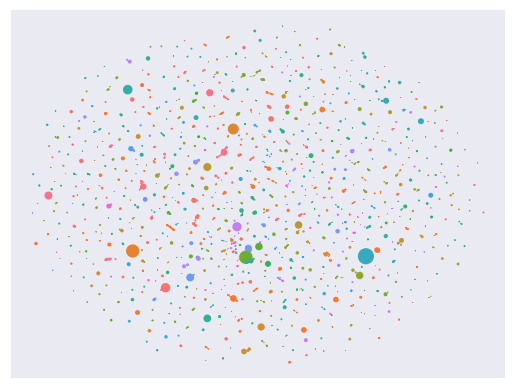

In [31]:
DTCRU.UMAP_Plot(Load_Prev_Data=True,by_cluster=True, show_legend=False,freq_weight=True,scale=5000)

### Comparison between GIANA embeddings and DeepTCR embeddings

In [1]:
import pandas as pd

In [2]:
DTCRU_features_df = pd.read_csv("/global/scratch/users/zhoufd/TCR/saved_data/DTCRU_extracted_features_96.csv")

In [3]:
DTCRU_features_df

,CDR3_Beta,V_Beta,J_Beta,Label,0,1,2,3,4,5,...,86,87,88,89,90,91,92,93,94,95
0,CTCSADPGVNQDTQYF,TRBV1,TRBJ2-5,CNS.tsv,1.483973,1.323466,-2.755567,0.664117,-0.866709,1.160175,...,0.414778,-0.678165,1.388778,0.924426,0.474260,-0.925459,-0.739885,0.874268,-0.877819,0.136588
1,CASSQDGDSDYTF,TRBV5,TRBJ1-2,CNS.tsv,-2.899027,0.242992,1.320574,0.806081,1.662399,-3.176822,...,1.126411,-0.706346,-0.409152,-0.189778,-0.404253,-0.565571,0.447473,-0.936392,0.479874,0.097883
2,CASGEDTQYF,TRBV12-2+TRBV13-2,TRBJ2-5,CNS.tsv,-0.474789,1.185730,1.231558,-0.672750,-1.599195,-0.370246,...,0.720212,-1.288252,0.186221,0.296736,-0.850989,0.461510,-0.764709,0.957320,-0.183926,-0.375370
3,CGARENTEVFF,TRBV20,TRBJ1-1,CNS.tsv,-0.691140,-3.484074,-0.332619,-2.985649,0.054818,-0.374696,...,0.444702,-1.390318,-0.158185,1.365211,-2.173331,0.066888,0.385801,0.027966,-0.379033,-1.742724
4,CASSPDRDPGNTLYF,TRBV19,TRBJ1-3,CNS.tsv,0.235439,1.761115,0.086200,0.329526,1.563050,0.872593,...,-0.874560,0.838743,0.352562,-0.224655,-0.285486,-0.304716,1.048117,0.432930,0.783432,-0.021846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23156,CASSIWGARDTQYF,TRBV19,TRBJ2-5,Spleen.tsv,0.010537,2.767023,1.962894,-0.467967,0.384084,0.496808,...,-0.929688,-0.647954,0.687997,-0.319871,-0.715018,0.139956,-0.219925,0.470535,0.331471,0.474854
23157,CASSIWGANQDTQYF,TRBV19,TRBJ2-5,Spleen.tsv,0.675617,3.177677,0.412470,0.672005,-0.699017,1.057554,...,-0.392700,-0.259904,0.428897,0.542597,0.376476,-0.241755,-0.220137,0.479873,-0.262152,1.000831
23158,CASSIWESQNTLYF,TRBV19,TRBJ2-4,Spleen.tsv,-1.582025,0.817183,3.221372,-1.157090,0.061414,0.824870,...,-2.220633,-0.676779,-0.033694,-1.342259,-0.854200,0.507206,-0.185063,0.674642,-0.265568,0.306632
23159,CASSIWDWGTSQNTLYF,TRBV19,TRBJ2-4,Spleen.tsv,-0.555716,0.301476,0.551711,-1.390457,-1.537535,2.455806,...,-0.855586,-0.802135,0.237065,0.131814,-0.797417,1.401195,-0.751417,2.026575,-0.008997,-0.440797


In [4]:
# File paths
embedding_path = "/global/scratch/users/zhoufd/TCR/packages/GIANA/GIANA_output_no_trbv/giana_merged_trbv_strict_filter--RotationEncodingBL62.txt_EncodingMatrix.txt"


# Load GIANA embeddings
GIANA_features_df = pd.read_csv(embedding_path, sep="\t", header=None)
GIANA_features_df

,0,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,96,97
0,CAAGGDRGNTEVFF,TRBV13-3,0.296720,0.290054,0.181763,-0.051034,-0.346865,0.580242,-0.492829,0.623043,...,0.534093,0.548508,0.594903,0.326693,-0.453553,-0.563170,-0.554163,0.181178,-0.716009,-0.089898
1,CACLGTGAYAEQFF,TRBV31,-0.330413,-0.438601,-0.550938,-0.043808,-0.351609,0.251349,0.534093,0.548508,...,0.027839,0.026379,-0.417603,0.218099,0.535328,0.048330,0.078777,0.504649,-0.269721,-0.524168
2,CAFRGRGGQNTLYF,TRBV31,-0.330413,-0.438601,-0.550938,-0.043808,-0.351609,0.251349,0.534093,0.548508,...,0.534093,0.548508,0.594903,0.326693,-0.453553,-0.563170,-0.554163,0.181178,-0.716009,-0.089898
3,CAGRGGGSAETLYF,TRBV31,-0.330413,-0.438601,-0.550938,-0.043808,-0.351609,0.251349,0.534093,0.548508,...,0.161617,0.083978,0.091195,0.345470,-0.294153,0.298919,-0.608347,0.594359,-0.294738,0.486415
4,CAIAGTGNYAEQFF,TRBV12-2,-0.330413,-0.438601,-0.550938,-0.043808,-0.351609,0.251349,0.534093,0.548508,...,-0.335624,0.170363,0.423411,0.466816,-0.503472,-0.379369,0.149483,0.321768,0.285847,0.684699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22322,CAWSPQLLRDRGSQNTLYF,TRBV31,0.404660,-0.337488,0.005463,-0.226078,0.164972,0.058133,0.068103,0.518609,...,0.208611,-0.173046,-0.782782,0.103752,-0.537859,0.720856,-0.197778,-0.009423,-0.952307,0.570936
22323,CTCSAPRGGTGGGQDTQYF,TRBV1,0.609985,-0.698594,-0.111712,-0.529546,-0.556532,-0.008708,1.221859,1.126777,...,0.041264,1.171551,0.499151,0.627849,-0.354417,-0.405424,-1.498082,0.076119,-0.661185,0.294201
22324,CASSLALRDWGGANQDTQYF,TRBV3,-0.473648,-0.314594,-0.551121,0.225528,-0.794703,-0.673133,0.074833,-0.230645,...,-0.828453,0.793406,0.327659,0.767971,-0.404337,-0.221622,-0.794437,0.216708,0.340671,1.068798
22325,CASSQDQGTGRWESQNTLYF,TRBV2,1.146413,0.236237,1.181323,-0.283472,0.485646,0.044304,-1.149377,0.021349,...,0.695710,0.632486,0.686097,0.672163,-0.747706,-0.264251,-1.162510,0.775538,-1.010747,0.396517


In [5]:
esm_features_df = pd.read_csv("/global/scratch/users/zhoufd/TCR/saved_data/tcr_esm2_pca96.csv",)

esm_features_df

,cdr3,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC87,PC88,PC89,PC90,PC91,PC92,PC93,PC94,PC95,PC96
0,CASSDNFSNERLFF,0.671544,-0.181507,-0.421365,0.215710,0.150050,-0.166790,0.249112,-0.074322,-0.207823,...,-0.029023,0.020374,-0.002178,0.007528,0.014971,0.006137,0.016621,-0.008943,0.014760,0.006289
1,CASGDASGGTGQLYF,-0.466436,-0.037823,0.595156,-0.218254,-0.050265,-0.131754,0.230267,0.089698,-0.005666,...,0.024949,-0.022687,-0.002437,-0.013598,-0.004350,-0.012174,-0.001008,-0.007534,0.009461,0.016423
2,CASRDNANTEVFF,0.453940,0.349135,0.091950,0.074188,0.107740,-0.216224,-0.110922,-0.471074,-0.033497,...,0.008233,0.031010,-0.010774,-0.020480,0.013168,0.001285,0.007660,-0.002321,-0.012236,-0.018917
3,CTCSADPGVNQDTQYF,-0.400144,-0.455058,-0.208217,-0.454968,-0.040309,-0.102238,-0.124742,-0.268715,-0.069779,...,-0.017476,-0.030329,0.030102,0.029460,-0.038029,0.013058,-0.004529,-0.007984,-0.026519,0.002848
4,CASNGQGGNTLYF,0.104217,0.016788,0.299494,-0.460074,-0.083956,0.246572,-0.067042,-0.165683,-0.090556,...,0.006443,0.001351,0.008237,0.000206,-0.005046,-0.009350,-0.013229,0.005747,-0.000240,-0.012462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22376,CASTRGGGYAEQFF,-0.445197,-0.178080,0.459239,0.037053,-0.069746,0.159840,-0.107838,-0.033874,0.126486,...,0.000857,0.001794,-0.013061,0.016919,0.021230,0.002697,-0.002572,0.014176,-0.002841,-0.000962
22377,CGARDINERLFF,0.355722,-0.068072,0.140247,0.280621,-0.017762,0.231499,-0.231597,-0.374264,0.057045,...,-0.016816,0.010577,-0.009351,0.023418,-0.010133,-0.016543,0.009450,-0.015367,-0.005500,-0.004933
22378,CAWRVSTEVFF,0.570054,-0.213597,-0.012655,0.569474,-0.194795,0.243472,0.040462,-0.210072,0.212230,...,0.003727,0.000372,-0.000353,0.002063,-0.019008,0.001417,0.023448,-0.012883,0.007206,-0.003120
22379,CASSLDLGGDQDTQYF,-0.493042,0.673963,0.366840,0.137215,-0.027978,-0.464875,-0.488371,-0.016075,-0.223861,...,-0.057123,0.043994,-0.042016,0.037706,-0.064695,0.034863,-0.029001,-0.060025,-0.039634,-0.032989


In [6]:
import numpy as np
esm_features_df = esm_features_df.iloc[:, np.r_[0, 2:esm_features_df.shape[1]]]
DTCRU_features_df = DTCRU_features_df.iloc[:, np.r_[0, 4:DTCRU_features_df.shape[1]]]
GIANA_features_df = GIANA_features_df.iloc[:, np.r_[0, 2:GIANA_features_df.shape[1]]]

In [7]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform

# Step 1: Ensure unique CDR3_Beta sequences by averaging embeddings if duplicated
DTCRU_unique = DTCRU_features_df.groupby("CDR3_Beta").mean().reset_index()
GIANA_unique = GIANA_features_df.groupby(0).mean().reset_index()  # Column 0 contains CDR3_Beta in GIANA
esm_unique = esm_features_df.groupby("cdr3").mean().reset_index()

# Step 2: Find the common CDR3 sequences among all three datasets
common_cdr3 = set(DTCRU_unique["CDR3_Beta"]).intersection(GIANA_unique[0]).intersection(esm_unique["cdr3"])

# Step 3: Keep only common sequences and sort them
DTCRU_matched = DTCRU_unique[DTCRU_unique["CDR3_Beta"].isin(common_cdr3)].sort_values("CDR3_Beta").reset_index(drop=True)
GIANA_matched = GIANA_unique[GIANA_unique[0].isin(common_cdr3)].sort_values(by=0).reset_index(drop=True)
esm_matched = esm_unique[esm_unique["cdr3"].isin(common_cdr3)].sort_values("cdr3").reset_index(drop=True)

# Step 4: Extract embeddings
DTCRU_embeddings = DTCRU_matched.iloc[:, 1:].values  # Exclude CDR3_Beta (first column)
GIANA_embeddings = GIANA_matched.iloc[:, 1:].values  # Exclude CDR3_Beta (first column)
esm_embeddings = esm_matched.iloc[:, 1:].values  # Exclude cdr3 (first column)

# Step 5: Compute pairwise distances within each embedding space
DTCRU_distances = squareform(pdist(DTCRU_embeddings, metric="euclidean"))
GIANA_distances = squareform(pdist(GIANA_embeddings, metric="euclidean"))
esm_distances = squareform(pdist(esm_embeddings, metric="euclidean"))

# Step 6: Flatten upper triangle of the distance matrices for correlation analysis
DTCRU_distances_flat = DTCRU_distances[np.triu_indices_from(DTCRU_distances, k=1)]
GIANA_distances_flat = GIANA_distances[np.triu_indices_from(GIANA_distances, k=1)]
esm_distances_flat = esm_distances[np.triu_indices_from(esm_distances, k=1)]




In [13]:
import numpy as np
from scipy.stats import spearmanr

# Randomly subsample 100,000 pairs for faster correlation
sample_size = min(100000, len(DTCRU_distances_flat))  # Adjust sample size if needed
indices = np.random.choice(len(DTCRU_distances_flat), size=sample_size, replace=False)

# Compute Spearman on subsampled data
spearman_DG, p_DG = spearmanr(DTCRU_distances_flat[indices], GIANA_distances_flat[indices])
spearman_DE, p_DE = spearmanr(DTCRU_distances_flat[indices], esm_distances_flat[indices])
spearman_GE, p_GE = spearmanr(GIANA_distances_flat[indices], esm_distances_flat[indices])
results = pd.DataFrame({
    "Comparison": ["DTCRU vs GIANA", "DTCRU vs ESM", "GIANA vs ESM"],
    "Spearman Correlation": [spearman_DG, spearman_DE, spearman_GE],
    "p-value": [p_DG, p_DE, p_GE]
})
results 

,Comparison,Spearman Correlation,p-value
0,DTCRU vs GIANA,0.208825,0.0
1,DTCRU vs ESM,0.143934,0.0
2,GIANA vs ESM,0.325328,0.0


In [19]:
DTCRU_features_df.shape

(23161, 97)

In [15]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_completeness_v_measure
import pandas as pd

# Perform K-Means clustering for all three datasets
DTCRU_clusters = KMeans(n_clusters=10, random_state=1, n_init=10).fit_predict(DTCRU_embeddings)
GIANA_clusters = KMeans(n_clusters=10, random_state=1, n_init=10).fit_predict(GIANA_embeddings)
ESM_clusters = KMeans(n_clusters=10, random_state=1, n_init=10).fit_predict(esm_embeddings)

# Compute clustering similarity scores for all pairs
ari_DG = adjusted_rand_score(DTCRU_clusters, GIANA_clusters)  # DTCRU vs GIANA
ari_DE = adjusted_rand_score(DTCRU_clusters, ESM_clusters)    # DTCRU vs ESM
ari_GE = adjusted_rand_score(GIANA_clusters, ESM_clusters)    # GIANA vs ESM

nmi_DG = normalized_mutual_info_score(DTCRU_clusters, GIANA_clusters)
nmi_DE = normalized_mutual_info_score(DTCRU_clusters, ESM_clusters)
nmi_GE = normalized_mutual_info_score(GIANA_clusters, ESM_clusters)

hom_DG, comp_DG, v_DG = homogeneity_completeness_v_measure(DTCRU_clusters, GIANA_clusters)
hom_DE, comp_DE, v_DE = homogeneity_completeness_v_measure(DTCRU_clusters, ESM_clusters)
hom_GE, comp_GE, v_GE = homogeneity_completeness_v_measure(GIANA_clusters, ESM_clusters)

# Organize results in a DataFrame
clustering_results = pd.DataFrame({
    "Comparison": ["DTCRU vs GIANA", "DTCRU vs ESM", "GIANA vs ESM"],
    "ARI": [ari_DG, ari_DE, ari_GE],
    "NMI": [nmi_DG, nmi_DE, nmi_GE],
    "Homogeneity": [hom_DG, hom_DE, hom_GE],
    "Completeness": [comp_DG, comp_DE, comp_GE],
    "V-Measure": [v_DG, v_DE, v_GE]
})
clustering_results


,Comparison,ARI,NMI,Homogeneity,Completeness,V-Measure
0,DTCRU vs GIANA,0.558085,0.701195,0.692718,0.709882,0.701195
1,DTCRU vs ESM,0.114138,0.183159,0.182416,0.183907,0.183159
2,GIANA vs ESM,0.174990,0.243102,0.245105,0.241132,0.243102


/global/home/users/zhoufd/.conda/envs/deeptcr_env/lib/python3.8/site-packages/numba/core/typed_passes.py:326: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../home/users/zhoufd/.conda/envs/deeptcr_env/lib/python3.8/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  warnings.warn(errors.NumbaPerformanceWarning(msg,
/global/home/users/zhoufd/.conda/envs/deeptcr_env/lib/python3.8/site-packages/umap/nndescent.py:91: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.or

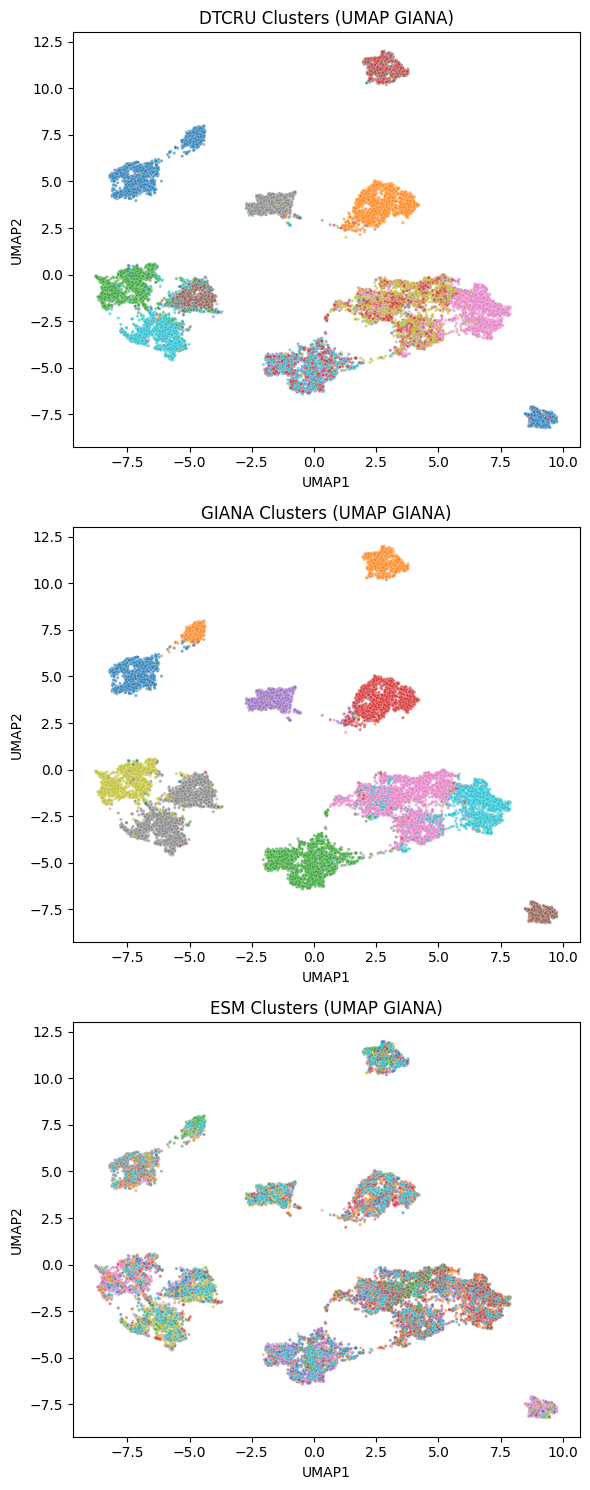

In [16]:
import umap
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Reduce dimensionality using only GIANA embeddings
umap_giana = umap.UMAP(n_components=2).fit_transform(GIANA_embeddings)

# Create dataframe for UMAP representation
df_umap = pd.DataFrame(umap_giana, columns=["UMAP1", "UMAP2"])
df_umap["DTCRU_Cluster"] = pd.Categorical(DTCRU_clusters)  # DTCRU clusters
df_umap["GIANA_Cluster"] = pd.Categorical(GIANA_clusters)  # GIANA clusters
df_umap["ESM_Cluster"] = pd.Categorical(ESM_clusters)  # ESM clusters

# Set up a 3x1 subplot (3 plots)
fig, axes = plt.subplots(3, 1, figsize=(6, 15))
titles = ["DTCRU Clusters (UMAP GIANA)", "GIANA Clusters (UMAP GIANA)", "ESM Clusters (UMAP GIANA)"]

# Define color palettes
dtcru_palette = sns.color_palette("tab10", len(df_umap["DTCRU_Cluster"].unique()))
giana_palette = sns.color_palette("tab10", len(df_umap["GIANA_Cluster"].unique()))
esm_palette = sns.color_palette("tab10", len(df_umap["ESM_Cluster"].unique()))

# Plot 1: DTCRU Clusters using GIANA UMAP
sns.scatterplot(data=df_umap, x="UMAP1", y="UMAP2", hue="DTCRU_Cluster", palette=dtcru_palette, alpha=0.6, s=5, ax=axes[0])
axes[0].set_title(titles[0])
axes[0].legend_.remove()

# Plot 2: GIANA Clusters using GIANA UMAP
sns.scatterplot(data=df_umap, x="UMAP1", y="UMAP2", hue="GIANA_Cluster", palette=giana_palette, alpha=0.6, s=5, ax=axes[1])
axes[1].set_title(titles[1])
axes[1].legend_.remove()

# Plot 3: ESM Clusters using GIANA UMAP
sns.scatterplot(data=df_umap, x="UMAP1", y="UMAP2", hue="ESM_Cluster", palette=esm_palette, alpha=0.6, s=5, ax=axes[2])
axes[2].set_title(titles[2])
axes[2].legend_.remove()

plt.tight_layout()
plt.show()




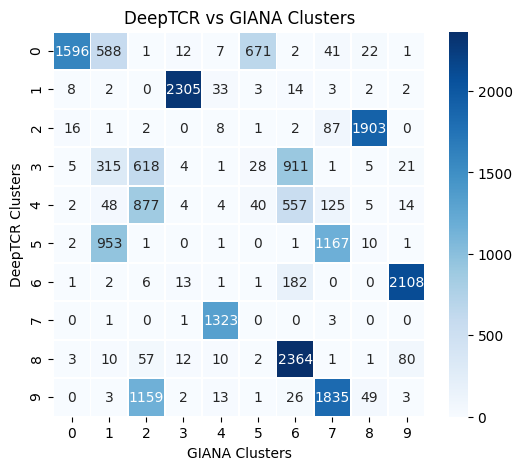

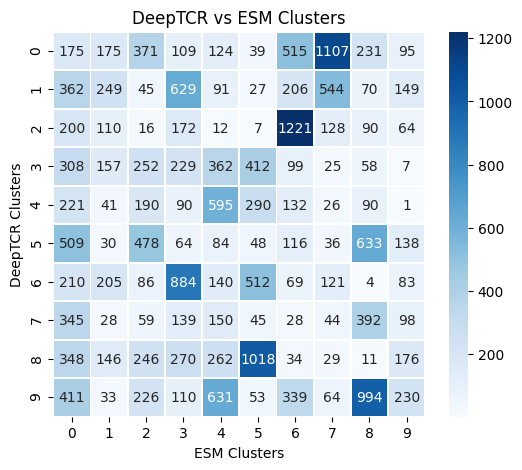

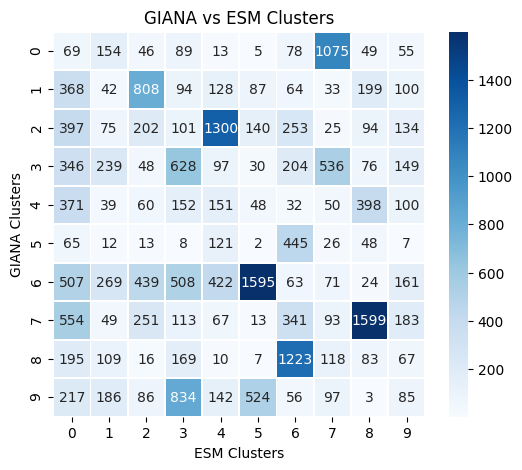

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create pairwise contingency tables
contingency_DG = pd.crosstab(DTCRU_clusters, GIANA_clusters)
contingency_DE = pd.crosstab(DTCRU_clusters, ESM_clusters)
contingency_GE = pd.crosstab(GIANA_clusters, ESM_clusters)

# Function to plot heatmap
def plot_heatmap(contingency_table, xlabel, ylabel, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(contingency_table, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

# Plot each heatmap
plot_heatmap(contingency_DG, "GIANA Clusters", "DeepTCR Clusters", "DeepTCR vs GIANA Clusters")
plot_heatmap(contingency_DE, "ESM Clusters", "DeepTCR Clusters", "DeepTCR vs ESM Clusters")
plot_heatmap(contingency_GE, "ESM Clusters", "GIANA Clusters", "GIANA vs ESM Clusters")
